<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/slakonet_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SlaKoNet: A Unified Slater-Koster Tight-Binding Framework Using Neural Network Infrastructure for the Periodic Table

https://doi.org/10.26434/chemrxiv-2025-4vjr9

# Table of contents

1. Install SlakoNet with Pypi or Git
2. Command line prediction example
3. Python Script example
4. Finetune model on your own dataset


Author: Kamal Choudhary (kchoudh2@jhu.edu)

Do you have any suggestions/requests for other tools? Raise a GitHub [issue](https://github.com/atomgptlab/slakonet/issues/new)

In [1]:
%%time
import os
# !pip install -q slakonet
os.mkdir('/content/Software')
os.chdir('/content/Software')
if not os.path.exists('slakonet'):
   !git clone https://github.com/atomgptlab/slakonet.git
os.chdir("slakonet")
!pip install -q -e .
os.chdir('/content')

Cloning into 'slakonet'...
remote: Enumerating objects: 307, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 307 (delta 178), reused 160 (delta 70), pack-reused 0 (from 0)
Receiving objects: 100% (307/307), 5.13 MiB | 6.22 MiB/s, done.
Resolving deltas: 100% (178/178), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 25.1 MB/s eta 0:00:00
CPU times: user 2.86 s, sys: 1.04 s, total: 3.9 s
Wall time: 25.2 s


## Command line prediction example

In [3]:
%%time
# Loading the model into memory takes a couple of minutes

!predict_slakonet.py  --file_path /content/Software/slakonet/slakonet/examples/POSCAR-JVASP-107.vasp

/usr/local/bin/predict_slakonet.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('slakonet==2025.9.1')
100% 183M/183M [00:06<00:00, 26.2MiB/s]
✅ Compact model loaded from: /content/Software/slakonet/slakonet/slakonet_v0/slakonet_v0.pt
Time taken: 153.394
/usr/local/lib/python3.12/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]
fermi energy tensor([[-0.0909]], requires_grad=True)
Fermi: -2.473 eV | Gap: 3.739 eV
CPU times: user 393 ms, sys: 92.4 ms, total: 486 ms
Wall time: 3min 13s


In [4]:
!ls

sample_data  slakonet_bands_dos.png  Software


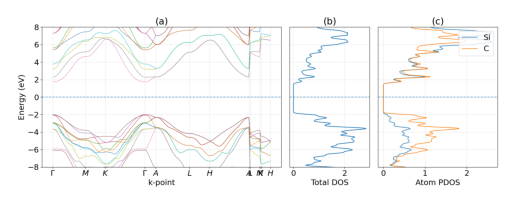

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(plt.imread('slakonet_bands_dos.png'))
plt.axis('off')
plt.show()



## Script example

In [ ]:
%%time
from slakonet.optim import (
    MultiElementSkfParameterOptimizer,
    get_atoms,
    kpts_to_klines,
    default_model,
)
from jarvis.core.kpoints import Kpoints3D as Kpoints

import torch
from slakonet.atoms import Geometry
from slakonet.main import generate_shell_dict_upto_Z65

model = default_model()

In [2]:
%%time

# Get structure (example with JARVIS ID)
atoms, opt_gap, mbj_gap = get_atoms("JVASP-107")
kpoints = Kpoints().kpath(atoms, line_density=20)
klines = kpts_to_klines(kpoints.kpts, default_points=2)
geometry = Geometry.from_ase_atoms([atoms.ase_converter()])
# or provide kpoints as grid
# kpoints = torch.tensor([3,3,3])
shell_dict = generate_shell_dict_upto_Z65()

# Compute electronic properties
with torch.no_grad():
    properties, success = model.compute_multi_element_properties(
        geometry=geometry,
        shell_dict=shell_dict,
        klines=klines,
        #kpoints=kpoints,
        get_fermi=True,
        #device="cuda"
    )

# Access results
print(f"Band gap: {properties['band_gap_eV']:.3f} eV")
print(f"Fermi energy: {properties['fermi_energy_eV']:.3f} eV")

# Plot band structure and DOS
eigenvalues = properties["eigenvalues"]
dos_values = properties['dos_values_tensor']
dos_energies = properties['dos_energy_grid_tensor']

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


/usr/local/lib/python3.12/dist-packages/jarvis/analysis/structure/spacegroup.py:315: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._dataset["number"]


fermi energy tensor([[-0.0909]], requires_grad=True)
Band gap: 3.739 eV
Fermi energy: -2.473 eV
CPU times: user 19.1 s, sys: 926 ms, total: 20 s
Wall time: 21.2 s


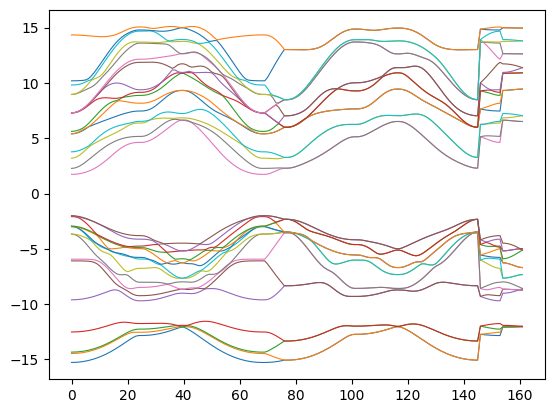

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
# From: https://github.com/atomgptlab/slakonet/blob/main/slakonet/predict_slakonet.py
# Bands: energy relative to Fermi
H2E = 27.21138505  # Hartree to eV
fermi_eV = float(properties["fermi_energy_eV"])  # scalar eV
eigenvalues = properties["calc"].eigenvalue * H2E
for i in range(eigenvalues.shape[-1]):
    y = eigenvalues[0, :, i].real.detach().cpu().numpy() - fermi_eV
    plt.plot(y, linewidth=0.8)

## Finetune model on your own dataset

In [10]:
import os
os.chdir('/content/Software/slakonet')
# Adjust xml_folder_path in your config_example.json
!train_slakonet.py --config_name /content/Software/slakonet/slakonet/examples/config_example.json

/usr/local/bin/train_slakonet.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('slakonet==2025.9.1')
Loading cached model from /content/Software/slakonet/slakonet/slakonet_v0/slakonet_v0.pt
✅ Compact model loaded from: /content/Software/slakonet/slakonet/slakonet_v0/slakonet_v0.pt
Time taken: 169.307
LOADING MULTIPLE VASP DATASETS
Found 2 VASP calculations:
   1. slakonet/tests/vasprun-1002.xml
   2. slakonet/tests/vasprun-107.xml
_load_single_dataset {'index': 0, 'vasprun_path': 'slakonet/tests/vasprun-1002.xml', 'geometry': Geometry(Si2), 'target_energy': 1125.91021985, 'target_bandgap': np.float64(1.2763999999999998), 'target_dos': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'dos_energies': tensor([-9.2109, -9.1991, -9.1873,  ..., 49.6796, 49.6914, 49.7032]), 'elements': {'Si'}, 'composition': OrderedDict({'Si': 2}), 'metadata': {'natoms': 2, 'formula': 'Si', 'volume': 41.44